\newpage

In [785]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV
from ucimlrepo import fetch_ucirepo 
from sklearn.neighbors import KNeighborsClassifier

import nltk
nltk.download('punkt')
wine = fetch_ucirepo(id=186) 

[nltk_data] Downloading package punkt to /Users/michael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [786]:
# 1 How many observations and features (variables)
all = wine.data.original
all.shape

(6497, 13)

There are 6497 observations, there are 13 features variables (color is other(categorical) and quality is target)

In [787]:
#2 what type of attributes
var_inf = wine.variables
print(var_inf)

                    name     role         type demographic  \
0          fixed_acidity  Feature   Continuous        None   
1       volatile_acidity  Feature   Continuous        None   
2            citric_acid  Feature   Continuous        None   
3         residual_sugar  Feature   Continuous        None   
4              chlorides  Feature   Continuous        None   
5    free_sulfur_dioxide  Feature   Continuous        None   
6   total_sulfur_dioxide  Feature   Continuous        None   
7                density  Feature   Continuous        None   
8                     pH  Feature   Continuous        None   
9              sulphates  Feature   Continuous        None   
10               alcohol  Feature   Continuous        None   
11               quality   Target      Integer        None   
12                 color    Other  Categorical        None   

               description units missing_values  
0                     None  None             no  
1                     None  Non

Except the color is categorical, quality is integer, and other rest of features are continuous 

3) quality   serves as the response (target)

In [788]:

#4 there are no missing values(also can check the info from website)

print(var_inf["missing_values"].unique())



['no']


In [789]:
##5 Display five rows from the original dataset

all.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


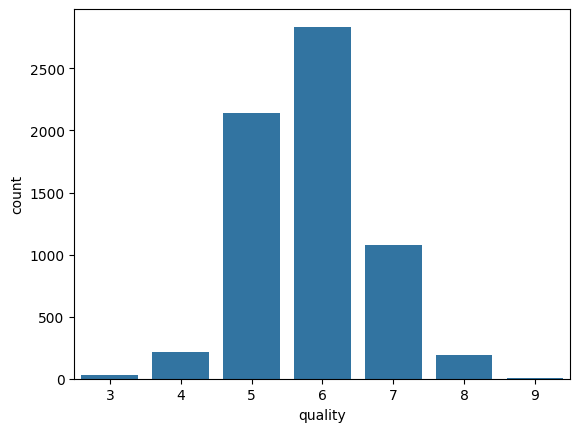

In [790]:
#6 

X = wine.data.features
y = wine.data.targets
sns.countplot(
    data=y,
    x = 'quality'
)

plt.show()

In [791]:
# Change 'quality' column to a categorical type
wine_filtered['quality'] = wine_filtered['quality'].astype('category')

# Check unique values in the 'quality' column
unique_quality_values = wine_filtered['quality'].unique()
print(unique_quality_values)

# Check if conversion completed  
print(wine_filtered.dtypes)


[5, 6, 7]
Categories (3, int64): [5, 6, 7]
fixed_acidity            float64
volatile_acidity         float64
citric_acid              float64
residual_sugar           float64
chlorides                float64
free_sulfur_dioxide      float64
total_sulfur_dioxide     float64
density                  float64
pH                       float64
sulphates                float64
alcohol                  float64
quality                 category
color_white                 bool
dtype: object


The dataset is imbalanced, with a higher concentration around quality 5 and 6. Like quality score 3 and quality score 9 have very few instances, which may cause a biased model performance.

Because the quality(respond variable) is integer, we need to convert integer to categorical for classification problem( No need transformation for regression)

In [792]:
#7 Remove observations with quality scores of 3, 4, 8, and 9
wine_filtered = all[~all['quality'].isin([3, 4, 8, 9])]
wine_filtered.shape


(6053, 13)

8) After filtering, how many unique quality scores remain in the dataset?


In [793]:
##8
unique_quality_scores = wine_filtered['quality'].nunique()
print(unique_quality_scores)
print(f"There are {unique_quality_scores} quality scores remain in the dataset.")

3
There are 3 quality scores remain in the dataset.


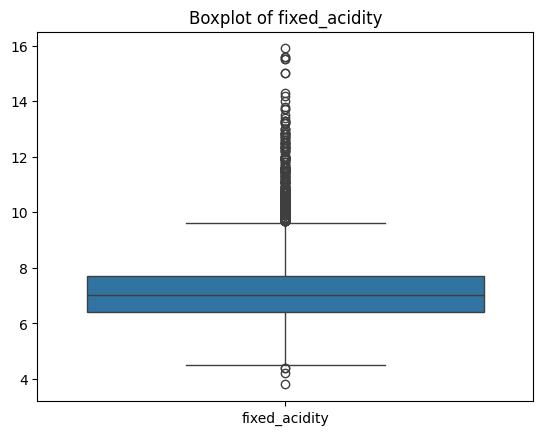

In [794]:
# 9 Check the distribution of features for any outliers
features = ['fixed_acidity']
for feature in features:
    if feature in wine_filtered.columns:
        plt.figure()
        sns.boxplot(data=wine_filtered[[feature]])
        plt.title(f'Boxplot of {feature}')
        plt.show

After constructing boxplot for each features, Any data point above the upper cutoff or below the lower cutoff is considered an outlier.
(Lower cutoff= quantile1 - 1.5*IQR , upper cutoff= quantile3 + 1.5*IQR )
(IQR= Q3-Q1)

In [795]:

# 10 Separate the predictors and the response variable from filtered dataset.
Y = wine_filtered['quality'].astype('category')
X = wine_filtered.drop(columns=['quality'])  # Drop the target column to get features
Y = wine_filtered['quality']  # Select the target column

11 
Since the color contains categorical data, classification trees require numeric features, so we need to convert color into a numerical format. One-hot encoding need to be applied to transfer a new binary column(like 1 if white,0 if red), for training a classification tree model. 

In [796]:

# Apply one-hot encoding to the 'color' column
wine_filtered = pd.get_dummies(wine_filtered, columns=['color'], drop_first=True)

In [797]:
## All of the feature is numeric，good for training tree model
print(wine_filtered.dtypes)  

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color_white                bool
dtype: object


In [826]:
# Re-define X and y after encoding
X = wine_filtered.drop(columns=['quality'])  # Features (numeric only)
y = wine_filtered['quality']  # Target variable




In [799]:
# 12 Split the dataset (filtered in Part (10) and transformed in Part (11)) into training (80%) and testing (20%) subsets.
X_train, X_test, y_train, y_test = train_test_split(
X,
Y,
test_size=0.2,
random_state=0,
stratify=Y
)


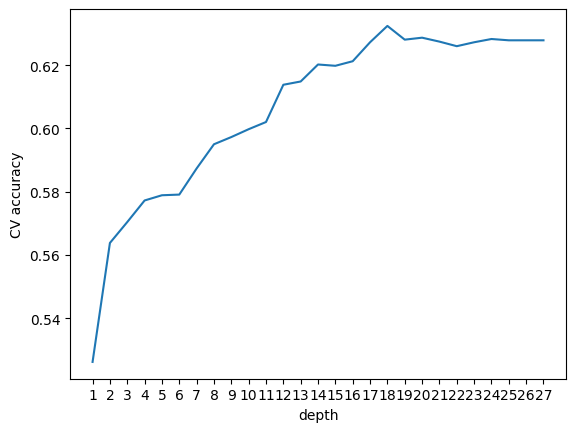

In [818]:

depth_range = range(1, 28)
cv_scores = []
for k in depth_range:
    dt = DecisionTreeClassifier(
        criterion='gini', # growing tree based on gini index
        random_state=0, 
        max_depth=k
        )
    
    # 5-fold cross-validation using accuracy 
    cv_scores_k = cross_val_score(
        dt,
        X_train,
        y_train,
        cv=5,
        # accuracy for classification on the hold-out folds
        scoring='accuracy'  
    )
    
    # append the average accuracy across all folds
    cv_scores.append(np.mean(cv_scores_k))
    
plt.plot(depth_range, cv_scores)
plt.xlabel('depth')
plt.ylabel('CV accuracy')
plt.xticks(range(1,28))
plt.show()

In [825]:
##Best cross-validation accuracy
round(max(cv_scores), 2)  



np.float64(0.63)

In [824]:
best_depth = depth_range[np.argmax(cv_scores)]
print("Optimal max depth:", best_depth)

Optimal max depth: 18


In [823]:
# Evaluate the final performance of the best model on the test data
dt_best = DecisionTreeClassifier(
    max_depth = 18, 
    random_state=0
    ) 
dt_best.fit(X_train, y_train)
test_accuracy = dt_best.score(X_test, y_test)
print(round(test_accuracy,2))

print(f'Test accuracy is {test_accuracy:.2f}')

0.65
Test accuracy is 0.65


The best cross_validation(CV) accuracy reached at 0.63(63%), the best model that trained with maxdepth 18 and reached a test accuracy of 0.65 (65%), which can confirm the model perform slightly better on the test than during cross-validation.
The model generalize well and does not overfit significantly. There might be some bias in the model since the improvement is not very much. (Remove less relevant features and check if any important feature is missing, and ensemble methods might be needed for higher performance)

/var/folders/sx/00v4vsfs2vs4gnsz544px2s80000gn/T/ipykernel_23324/3839289009.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Feature', x='Importance', data=importances_df, palette="viridis")


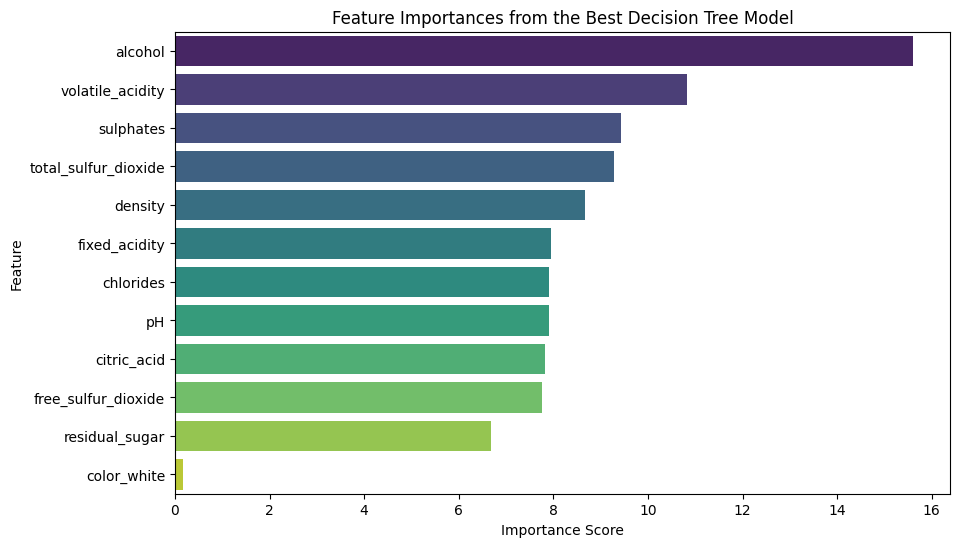

Top 2 most important features for predicting wine quality:
             Feature  Importance
10           alcohol   15.602745
1   volatile_acidity   10.834472


In [806]:
#14 Using best classification tree model, identify the two most important features

# Get feature importances from the best decision tree model
feature_importance = dt_best.feature_importances_ * 100  # Use correct model variable

# Create a DataFrame for better visualization
importances_df = pd.DataFrame({
    'Feature': X_train.columns,  # Ensure correct feature names
    'Importance': feature_importance
})

# Sort the DataFrame by importance in descending order
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(y='Feature', x='Importance', data=importances_df, palette="viridis")
plt.title('Feature Importances from the Best Decision Tree Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Display the top 2 most important features
print("Top 2 most important features for predicting wine quality:")
print(importances_df.head(2))

#15
The classification tree model achieved a cross-validation accuracy of 63% and a final test accuracy of 65%, showing a moderate predictive ability without overfitting.
The model identifies alcohol content and volatile acidity as the most important predictors, which means these factors significantly influence wine quality ratings.The chemical composition of the wine plays a significant role in determining its quality. However, wine quality score may also depend on other features like personal subjective opinion external influences that are not captured by this dataset. Further improvements could be made by exploring more sophisticated models, such as random forests or boosting methods, to get a higher performance.

In [807]:
# 16 Create copies of X_train and X_test
X_train2 = X_train.copy()
X_test2 = X_test.copy()

#17
Yes, additional data transformation is necessary before  training a KNN classifier. Because KNN relies on distance calculations, features need to be standardized to ensure fair comparisons. We use StandardScaler to normalize the numerical features in X_train2 and X_test2. Otherwise, the distance will be dominated by the feature who has large value range. 
Other transformations like encoding categorical features or outlier handling might also be needed depending on the dataset.

In [808]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train2_scaled = scaler.fit_transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)

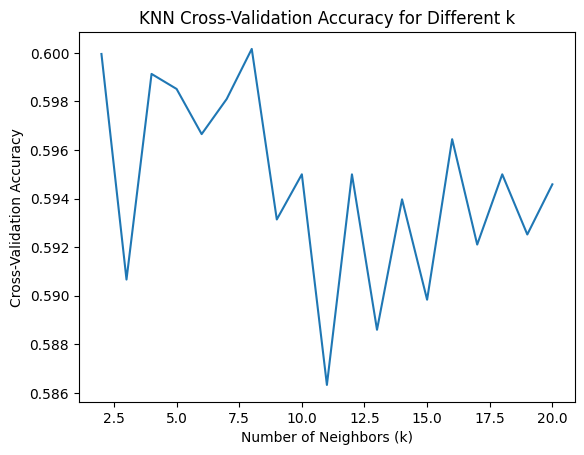

The best number of neighbors is 8 with a cross-validation accuracy of 0.60
Test accuracy of the best KNN model: 0.59


In [809]:
#18 Using the training data (`X_train2`, `y_train`), train a K-Nearest Neighbors (KNN) 
# classifier and perform model selection through cross-validation (e.g., tuning the neighborhood size).

# Define the range of k values and perform cross-validation for each k
k_range = range(2, 21)
cv_scores_knn = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores_k = cross_val_score(knn, X_train2_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores_knn.append(np.mean(cv_scores_k))

# Plot the cross-validation accuracy for each k
plt.plot(k_range, cv_scores_knn)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('KNN Cross-Validation Accuracy for Different k')
plt.show()

# Find the best k and train the best KNN model on the training data
best_k = k_range[np.argmax(cv_scores_knn)]
print(f'The best number of neighbors is {best_k} with a cross-validation accuracy of {max(cv_scores_knn):.2f}')
 
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train2_scaled, y_train)

# Evaluate the final performance
test_accuracy_knn = knn_best.score(X_test2_scaled, y_test)
print(f'Test accuracy of the best KNN model: {test_accuracy_knn:.2f}')

19) Write at least one statement summarizing the KNN classifier model's performance and its implications in the context of the dataset and the problem.


#19 statement on KNN

The the best number of neighbors for KNN model is 8, reaching a cross-validation accuracy of 60%. The model achieved a test accuracy of 59%. The test accuracy (59%) is slightly lower than the cross-validation accuracy (60%) which indicate that the model might have slightly overfitted to the training data but still generalizes reasonably well.
Overall, the model's accuracy is moderate, which imply that more complex relationships exist in the data that might be better captured by more sophisticated model, such as ensemble methods.

20 Compare and contrast Cross-validation and KNN

The classification tree reached a cross-validation accuracy of 63% and test accuracy of 65%. The KNN classifier reached a cross-validation accuracy of 60% and a final test accuracy of 59%. Classification tree model performed a little bit better based on these features. KNN model might be affected by local variations in the dataset, whereas the decision tree can analyze the data more effectively. The classification tree model's performance mainly depends on the max_depth parameter, and KNN is mainly sensitive to the k.

The classification tree perform better test accuracy implies that it captures more relevant decision boundaries in this dataset. KNN is a non-parametric model and does not learn explicit rules. Its performance might degrade when dealing with large datasets. KNN might need more advanced modeling methods to improve performance.

The decision tree shows explicit decision rules and features rankings of the influence factors to the wine quality. We can easily see the alcohol and volatile acidity are the most influential factors on the wine quality. KNN does not provide explicit feature importance, as it relies on distance predictions, making it harder to interpret which features is impactful.
